In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
from sklearn.datasets import make_blobs
color_list = ['r', 'g', 'y', 'm']

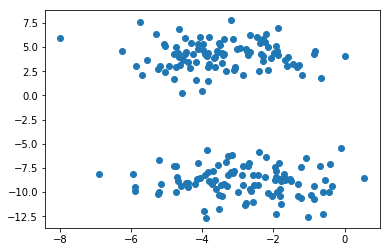

In [3]:
dataset = make_blobs(n_samples=200, n_features=2, centers=2, cluster_std=1.5)
data = dataset[0]
datax = data[:,0]
datay = data[:,1]
label = dataset[1]

plt.scatter(data[:,0], data[:,1])

In [41]:
class DBScan(object):
    
    def __init__(self, data=None, epsilon=1.0, min_points=5):
        self.data:np.ndarray
        self.distances:np.ndarray
        self.n_insides:np.ndarray
        self.classes:np.ndarray
        self.cluster:np.ndarray
        
        self.epsilon = epsilon
        self.min_points = min_points
        if data is not None:
            self.set_data(data)
        
        self.CORE = 0
        self.BORDER = 1
        self.NOISE = 2
        
        self.visited = []
        
    def set_data(self, data):
        self.data = data
        self.distances = np.zeros((len(data), len(data)))
        self.n_insides = np.zeros(len(data), dtype=int)
        self.classes = np.zeros(len(data))
        self.cluster = np.zeros(len(data))

        
    def _distance(self, point1, point2):
        diff = point1 - point2 # difference between center and data point
        sqrd = np.square(diff) # elementwise squaring
        axis = 1 if len(sqrd.shape) == 2 else None
        sumd = np.sum(sqrd, axis=axis) # not summing all data. but only n_features,i.e. columns (axis = 1)
        sqrt = np.sqrt(sumd) # square root after sum
        return sqrt
    
    def calculate_distance_matrix(self):
        for i in range(len(self.data)-1):
            pti = self.data[i]
            pointafter_i = self.data[i+1:]
            dist = self._distance(pti, pointafter_i)
            self.distances[i, i+1:] = dist
            self.distances[i+1:, i] = dist
            
        return self.distances
    
    def classify_points_1(self):
        for i in range(len(self.data)):
            dists = self.distances[i]
            n_inside = np.count_nonzero(dists < self.epsilon)-1
            self.n_insides[i] = n_inside
            if n_inside >= self.min_points:
                self.classes[i] = self.CORE
            else:
                self.classes[i] = self.NOISE
        return self.classes
    
    
    def classify_points_2(self):
#         cpf = np.copy(cp)
        cls0 = self.data[self.classes==0]
        for i in range(len(self.data)):
            if self.classes[i] == 0: continue # ignore the core points

            dists = self.distances[i]
            n_inside = self.n_insides[i]
            min_dist_pts = dists.argsort()[1:n_inside+1]
            
            for dat in self.data[min_dist_pts]:
                if dat in cls0:
                    self.classes[i] = self.BORDER
                    break
        return self.classes
    
    def classify_points(self):
        self.classify_points_1()
        self.classify_points_2()
        return self.classes
    
    def find_unvisited_cluster_point(self):
        point = None
        for i in range(len(self.classes)):
            if self.cluster[i] > 0:
                continue
            if self.classes[i] == self.NOISE:
                continue
            point = i
        return point
    

    def __find_rechable_points(self, start_pt):
        if start_pt >= len(self.data):
#             print(f'{start_pt} is above data size')
            return
        if self.classes[start_pt] == self.NOISE:
#             print(f'{start_pt} is a noise point')
            return
        if start_pt in self.visited:
#             print(f'{start_pt} is already visited')
            return


        self.visited.append(start_pt)
        dists = self.distances[start_pt]
        n_inside = self.n_insides[start_pt]
        min_dist_pts = dists.argsort()[1:n_inside+1]
        for pts in min_dist_pts:
            self.__find_rechable_points(pts)
    
    def find_rechable_points(self, start_pt):
        self.visited = []
        self.__find_rechable_points(start_pt)
        reached = np.array(self.visited)
        self.visited = []
        return reached
            
    
    def make_cluster(self):
        for i in range(len(data)):
            clno = np.max(self.cluster) + 1
            cp = self.find_unvisited_cluster_point()
            if cp is None: break
            reached = self.find_rechable_points(cp)
            self.cluster[reached] = clno
        return self.cluster    

In [42]:
dbs = DBScan(data)

In [43]:
dbs.calculate_distance_matrix()

array([[ 0.        , 14.87792209, 11.39439962, ..., 11.27397411,
         3.09790979,  2.42710864],
       [14.87792209,  0.        ,  3.6992796 , ...,  4.92146977,
        17.96628155, 17.27729223],
       [11.39439962,  3.6992796 ,  0.        , ...,  1.858986  ,
        14.45203609, 13.75470402],
       ...,
       [11.27397411,  4.92146977,  1.858986  , ...,  0.        ,
        14.2272774 , 13.52418252],
       [ 3.09790979, 17.96628155, 14.45203609, ..., 14.2272774 ,
         0.        ,  0.70310008],
       [ 2.42710864, 17.27729223, 13.75470402, ..., 13.52418252,
         0.70310008,  0.        ]])

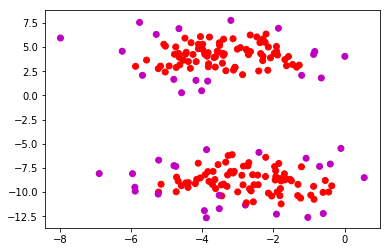

In [44]:
dbs.classify_points_1()
plt.scatter(data[:,0], data[:,1],
            c=dbs.classes,
            cmap=matplotlib.colors.ListedColormap(color_list))

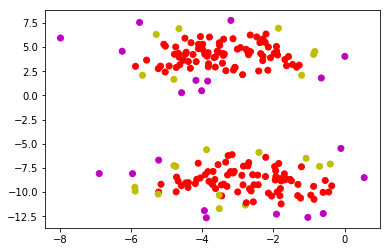

In [45]:
dbs.classify_points_2()
plt.scatter(data[:,0], data[:,1],
            c=dbs.classes,
            cmap=matplotlib.colors.ListedColormap(color_list))

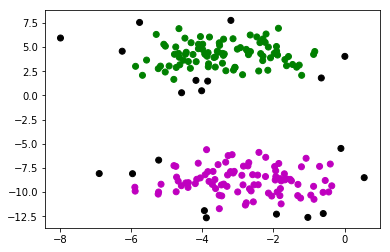

In [48]:
cluster = dbs.make_cluster()
plt.scatter(data[:,0], data[:,1],
            c=cluster,
            cmap=matplotlib.colors.ListedColormap(['black']+color_list))